In [2]:

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import seaborn.apionly as sns

from IPython.display import Image
from sklearn import preprocessing


%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']


In [1]:
import pandas as pd

df = pd.read_csv('/Users/desert/desert_workspace/desert_data/fd_data.csv')
df = df.drop(['Unnamed: 0','State'], axis=1)
df=df.fillna(0)
df.rename(columns={'Influenza Death (<65 years of age)':'senior_flu_deaths'}, inplace=True)
df.rename(columns={'Varicella Hospitalizations':'varicella_hospitalizations'}, inplace=True)
df.head()

,County,POP2010,food_deserts,n_tracts,urban_des,rural_des,n_urban,n_rural,des_percent,perc_effected,...,varicella_hospitalizations,Salmonellosis,opiods_rx_1000,opiods_greater_than_stateavg,MILK_PRICE10,SODA_PRICE10,MILK_SODA_PRICE10,PCH_FFR_07_12,FFR07,FFR12
0,Alameda,1510271,15,360,15.0,0.0,354,6,0.041667,0.018032,...,0.132,16.978,557.20,0,1.122215,1.164422,0.891575,8.902878,1112.0,1211
1,Alpine,1175,0,1,0.0,0.0,0,1,0.000000,0.266288,...,0.000,0.000,578.68,0,1.032918,1.089488,0.877073,-50.000000,2.0,1
2,Amador,38091,0,9,0.0,0.0,0,9,0.000000,0.149514,...,0.000,7.923,1244.76,1,1.032918,1.089488,0.877073,-5.555556,18.0,17
3,Butte,220000,14,51,13.0,1.0,38,13,0.274510,0.145583,...,0.455,25.913,1389.20,1,0.996443,1.130546,0.815374,2.684564,149.0,153
4,Calaveras,45578,0,10,0.0,0.0,2,8,0.000000,0.203345,...,0.000,8.800,1068.98,1,1.032918,1.089488,0.877073,-7.407407,27.0,25


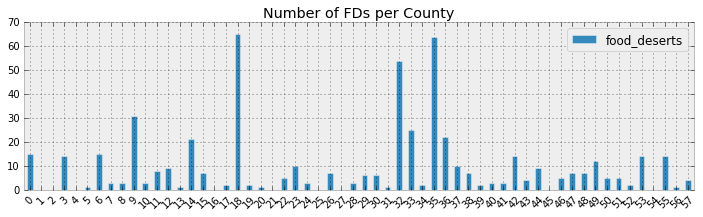

In [11]:
#/f, ax = plt.subplots(figsize=(16, 12))

df[['County','food_deserts']].plot(
    kind='bar', figsize=(12,3), title='Number of FDs per County', color=colors[0])
_ = ax.set_xlabel('county')
_ = ax.set_ylabel('Number of FDs')
_ = plt.xticks(rotation=45)

In [15]:
df.ix[18]

County                          Los Angeles
POP2010                             9818605
food_deserts                             65
n_tracts                               2334
urban_des                                65
rural_des                                 0
n_urban                                2293
n_rural                                  41
des_percent                       0.0278492
perc_effected                     0.0179679
LowIncomeTracts                        1137
low_vehicle_tracts                      210
total_housing_units                 3241204
pop_in_group_housing                 171681
pop_effected                         176420
cnty_obesity_pct                       21.3
cnty_obesity_pct_adj                   21.2
cnty_dm_pct                             7.7
cnty_dm_pct_adj                         7.8
cnty_inactive_pct                      18.1
cnty_inactive_pct_adj                  18.1
Adolescent_births                     30912
ABR                             

In [12]:
indiv_traces = {}

# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
participants_idx = le.fit_transform(df['County'])
participants = le.classes_
n_participants = len(participants)

for p in participants:
    with pm.Model() as model:
        alpha = pm.Uniform('alpha', lower=0, upper=100)
        mu = pm.Uniform('mu', lower=0, upper=100)
        
        data = df[df['County']==p]['food_deserts'].values
        y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=data)

        y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
        
        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(20000, step, start=start, progressbar=True)
        
        indiv_traces[p] = trace

Applied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 5.3 secApplied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 5.1 secApplied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 5.5 secApplied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 5.0 secApplied interval-transform to alpha and added transforme

In [13]:
fig, axs = plt.subplots(3,2, figsize=(12, 6))
axs = axs.ravel()
y_left_max = 2
y_right_max = 2000
x_lim = 100
ix = [3,4,6]

for i, j, p in zip([0,1,2], [0,2,4], df[ix]):
    axs[j].set_title('Observed: %s' % p)
    axs[j].hist(df[df['County']==p]['food_deserts'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
    axs[j].set_ylim([0, y_left_max])

for i, j, p in zip([0,1,2], [1,3,5], participants[ix]):
    axs[j].set_title('Posterior predictive distribution: %s' % p)
    axs[j].hist(indiv_traces[p].get_values('y_pred'), range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])
    axs[j].set_ylim([0, y_right_max])

axs[4].set_xlabel('food_deserts))
axs[5].set_xlabel('food_deserts))

#axs[5].set_xlabel('Response time (seconds)')

plt.tight_layout()

SyntaxError: EOL while scanning string literal (<ipython-input-13-43b095828b41>, line 18)

In [ ]:

combined_y_pred = np.concatenate([v.get_values('y_pred') for k, v in indiv_traces.items()])

x_lim = 60
y_pred = trace.get_values('y_pred')

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(combined_y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylim(0, 20000)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlim(0, x_lim)
_ = plt.xlabel('Response time in seconds')
_ = plt.ylim(0, 20)
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()